In [ ]:
from time import sleep
from json import loads
from kafka import KafkaConsumer
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'kafka'

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

In [ ]:
spark = SparkSession.builder \
    .appName("TopCarPerformacing") \
    .getOrCreate()

In [ ]:
schema = StructType([
    StructField("mpg", FloatType(), True),
    StructField("cylinders", IntegerType(), True),
    StructField("displacement", FloatType(), True),
    StructField("horsepower", StringType(), True),
    StructField("weight", IntegerType(), True),
    StructField("acceleration", FloatType(), True),
    StructField("model_year", IntegerType(), True),
    StructField("origin", IntegerType(), True),
    StructField("car_name", StringType(), True)
])


In [ ]:
# df = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)

In [ ]:
# df.show()

In [ ]:
consumer = KafkaConsumer('AutoMobile-Analysis', bootstrap_servers='localhost:9092',
                         value_deserializer=lambda x: loads(x.decode('utf-8')))


In [ ]:
#df = Dataframe()
print(consumer)
consumer

In [ ]:
data =[]
for consumer_data in consumer:
    data = consumer_data.value
    break
dataList = json.loads(data)

In [ ]:
df = pd.DataFrame(dataList)

In [ ]:
df.to_csv("carDetails", index=False)

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
cars = spark.read.format('csv').option('header','true').load('carDetails')
cars.createOrReplaceTempView('cars_stats')
cars.show()

+----+---------+------------+----------+------+------------+----------+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model_year|origin|            car_name|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
|18.0|        8|       307.0|       130|  3504|        12.0|        70|     1|chevrolet chevell...|
|15.0|        8|       350.0|       165|  3693|        11.5|        70|     1|   buick skylark 320|
|18.0|        8|       318.0|       150|  3436|        11.0|        70|     1|  plymouth satellite|
|16.0|        8|       304.0|       150|  3433|        12.0|        70|     1|       amc rebel sst|
|17.0|        8|       302.0|       140|  3449|        10.5|        70|     1|         ford torino|
|15.0|        8|       429.0|       198|  4341|        10.0|        70|     1|    ford galaxie 500|
|14.0|        8|       454.0|       220|  4354|         9.0|        70|     1|    chevrolet impala|


In [ ]:
#Identify and rank the top-performing car models based on fuel efficiency(mpg), taking into account the weight of the vehicle.
spark.sql("""
SELECT 
    car_name AS model,
    AVG(mpg) AS avg_mpg,
    AVG(horsepower) AS avg_horsepower
FROM cars_stats
WHERE cylinders >= 6
GROUP BY car_name
ORDER BY avg_mpg DESC
LIMIT 5
""").show()

+--------------------+-------+--------------+
|               model|avg_mpg|avg_horsepower|
+--------------------+-------+--------------+
|oldsmobile cutlas...|   38.0|          85.0|
|       datsun 280-zx|   32.7|         132.0|
|        volvo diesel|   30.7|          76.0|
|oldsmobile omega ...|   26.8|         115.0|
|oldsmobile cutlas...|   26.6|         105.0|
+--------------------+-------+--------------+



+--------------------+-------+--------------+
|               model|avg_mpg|avg_horsepower|
+--------------------+-------+--------------+
|oldsmobile cutlas...|   38.0|          85.0|
|oldsmobile omega ...|   26.8|         115.0|
|oldsmobile cutlas...|   26.6|         105.0|
|  chevrolet citation|  26.15|         112.5|
|buick century lim...|   25.0|         110.0|
+--------------------+-------+--------------+



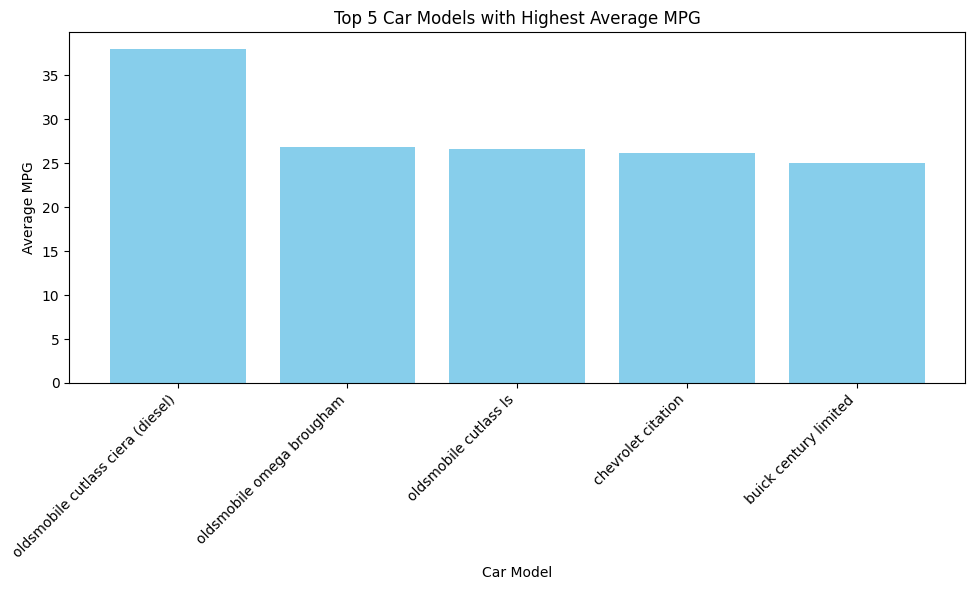

In [ ]:
#Goal: Identify the top 5 car models with the highest average miles per gallon (mpg), considering only models with at least 6 cylinders and manufactured in the USA, and display their average mpg and horsepower.
query = """
SELECT 
    model,
    avg_mpg,
    avg_horsepower
FROM (
    SELECT 
        car_name AS model,
        AVG(mpg) AS avg_mpg,
        AVG(horsepower) AS avg_horsepower,
        ROW_NUMBER() OVER (ORDER BY AVG(mpg) DESC) AS rank
    FROM cars_stats
    WHERE cylinders >= 6 
        AND origin = 1 -- Considering only cars manufactured in the USA
    GROUP BY car_name
    ) AS ranked_models
WHERE rank <= 5
"""
top_models = spark.sql(query)
top_models.show()
top_models_df = top_models.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_models_df['model'], top_models_df['avg_mpg'], color='skyblue')
plt.xlabel('Car Model')
plt.ylabel('Average MPG')
plt.title('Top 5 Car Models with Highest Average MPG')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

+----------+----------------------+----------------------+----------------------+
|model_year|percentage_4_cylinders|percentage_6_cylinders|percentage_8_cylinders|
+----------+----------------------+----------------------+----------------------+
|        70|                 24.14|                 13.79|                 62.07|
|        71|                 46.43|                 28.57|                  25.0|
|        72|                  50.0|                   0.0|                 46.43|
|        73|                  27.5|                  20.0|                  50.0|
|        74|                 55.56|                 25.93|                 18.52|
|        75|                  40.0|                  40.0|                  20.0|
|        76|                 44.12|                 29.41|                 26.47|
|        77|                  50.0|                 17.86|                 28.57|
|        78|                 47.22|                 33.33|                 16.67|
|        79|    

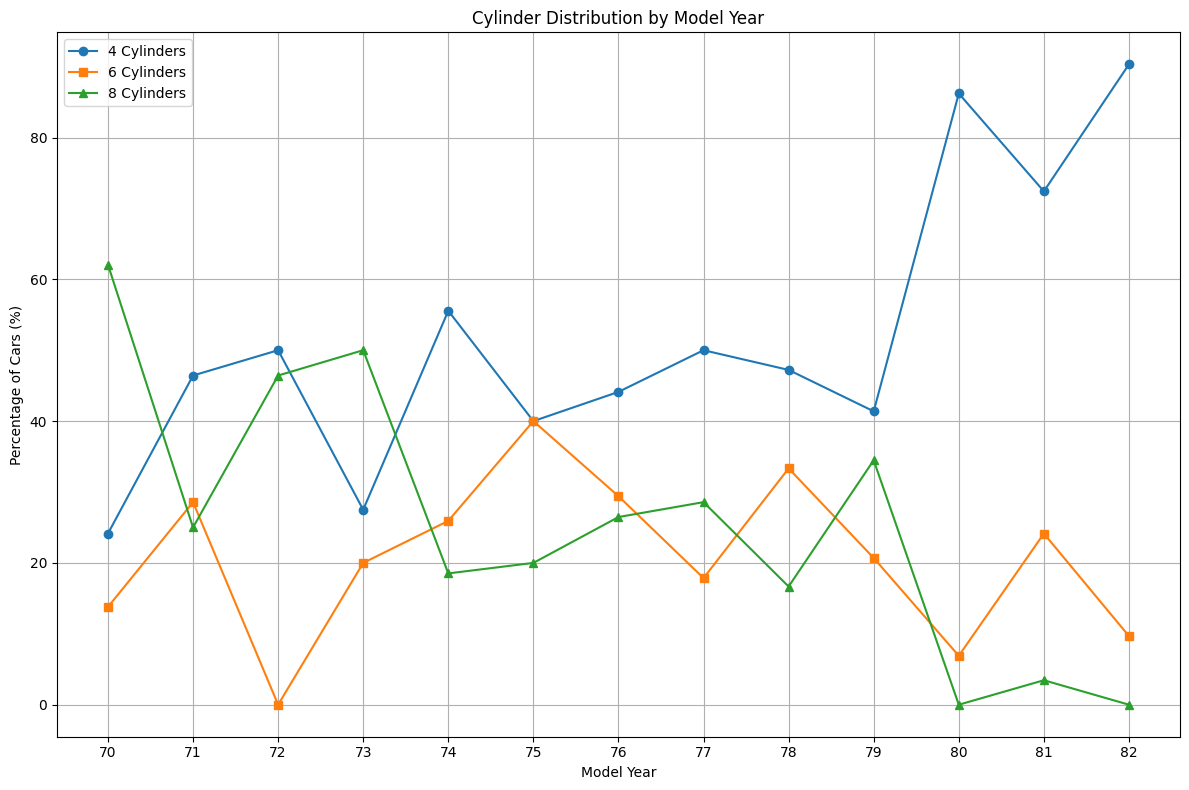

In [ ]:
#Determine the distribution of cylinders for cars manufactured in each model year, and visualize the percentage of cars with 4, 6, and 8 cylinders for each model year.

query = """
SELECT 
    model_year,
    ROUND((SUM(CASE WHEN cylinders = 4 THEN 1 ELSE 0 END) / COUNT(*)) * 100, 2) AS percentage_4_cylinders,
    ROUND((SUM(CASE WHEN cylinders = 6 THEN 1 ELSE 0 END) / COUNT(*)) * 100, 2) AS percentage_6_cylinders,
    ROUND((SUM(CASE WHEN cylinders = 8 THEN 1 ELSE 0 END) / COUNT(*)) * 100, 2) AS percentage_8_cylinders
FROM cars_stats
GROUP BY model_year
ORDER BY model_year
"""

cylinder_distribution = spark.sql(query)
cylinder_distribution.show()
cylinder_distribution_df = cylinder_distribution.toPandas()

plt.figure(figsize=(12, 8))
plt.plot(cylinder_distribution_df['model_year'], cylinder_distribution_df['percentage_4_cylinders'], marker='o', label='4 Cylinders')
plt.plot(cylinder_distribution_df['model_year'], cylinder_distribution_df['percentage_6_cylinders'], marker='s', label='6 Cylinders')
plt.plot(cylinder_distribution_df['model_year'], cylinder_distribution_df['percentage_8_cylinders'], marker='^', label='8 Cylinders')
plt.xlabel('Model Year')
plt.ylabel('Percentage of Cars (%)')
plt.title('Cylinder Distribution by Model Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


+-------------+------------------+
|         make|        avg_weight|
+-------------+------------------+
|           hi|            4732.0|
|     cadillac|            4140.0|
|     chrysler|            3912.0|
|    chevroelt|            3897.0|
|        chevy|            3717.0|
|      pontiac|         3655.3125|
|   oldsmobile|            3575.9|
|        buick|3553.3529411764707|
|mercedes-benz|            3535.0|
|     mercedes|            3530.0|
|      mercury|3428.5454545454545|
|         ford|3301.2156862745096|
|          amc|3280.6428571428573|
|    chevrolet|3276.0232558139537|
|     plymouth| 3218.967741935484|
|        dodge|           3206.25|
|        volvo|3032.6666666666665|
|      peugeot|           2972.75|
|         saab|           2625.25|
|        capri|            2572.0|
+-------------+------------------+
only showing top 20 rows



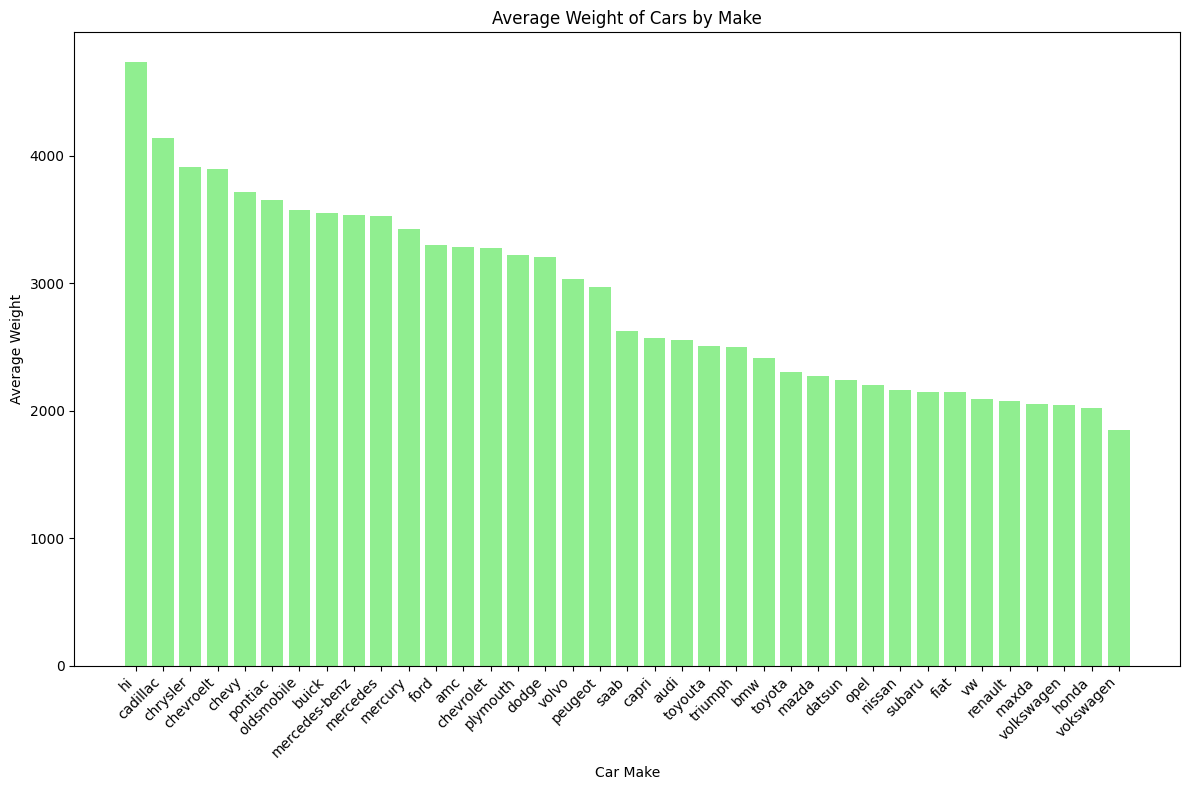

In [ ]:
#Goal: Calculate the average weight for cars manufactured by each make (e.g., Chevrolet, Ford), and determine which make has the highest average weight. Visualize the average weight of cars by each make.

query = """
SELECT 
    make,
    AVG(weight) AS avg_weight
FROM (
    SELECT 
        SUBSTRING_INDEX(car_name, ' ', 1) AS make,
        weight
    FROM cars_stats
    ) AS car_make_weight
GROUP BY make
ORDER BY avg_weight DESC
"""

average_weight_by_make = spark.sql(query)
average_weight_by_make.show()
average_weight_by_make_df = average_weight_by_make.toPandas()

plt.figure(figsize=(12, 8))
plt.bar(average_weight_by_make_df['make'], average_weight_by_make_df['avg_weight'], color='lightgreen')
plt.xlabel('Car Make')
plt.ylabel('Average Weight')
plt.title('Average Weight of Cars by Make')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


+--------------------+------------------------------+
|               model|avg_horsepower_to_weight_ratio|
+--------------------+------------------------------+
|buick estate wago...|           0.05423018723206907|
|  pontiac grand prix|          0.053763440860215055|
|  amc ambassador dpl|           0.04935064935064935|
+--------------------+------------------------------+



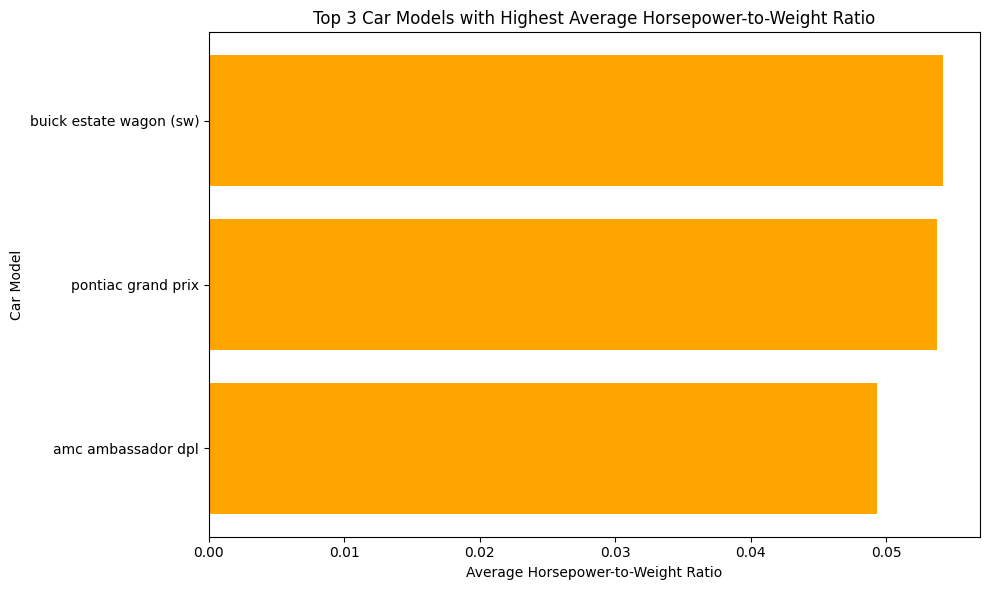

In [ ]:
#Goal: Determine the top 3 car models with the highest average horsepower-to-weight ratio (horsepower divided by weight), considering only models with at least 6 cylinders. Visualize the horsepower-to-weight ratio of these top models.

query = """
SELECT 
    model,
    avg_horsepower_to_weight_ratio
FROM (
    SELECT 
        car_name AS model,
        AVG(horsepower / weight) AS avg_horsepower_to_weight_ratio,
        ROW_NUMBER() OVER (ORDER BY AVG(horsepower / weight) DESC) AS rank
    FROM cars_stats
    WHERE cylinders >= 6
    GROUP BY car_name
    ) AS ranked_models
WHERE rank <= 3
"""

top_models_horsepower_weight_ratio = spark.sql(query)
top_models_horsepower_weight_ratio.show()
top_models_horsepower_weight_ratio_df = top_models_horsepower_weight_ratio.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(top_models_horsepower_weight_ratio_df['model'], top_models_horsepower_weight_ratio_df['avg_horsepower_to_weight_ratio'], color='orange')
plt.xlabel('Average Horsepower-to-Weight Ratio')
plt.ylabel('Car Model')
plt.title('Top 3 Car Models with Highest Average Horsepower-to-Weight Ratio')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()



+----------+----------+------------+
|model_year|num_models|total_models|
+----------+----------+------------+
|        70|        16|          29|
|        71|        13|          28|
|        72|        18|          28|
|        73|        19|          40|
|        74|        14|          27|
|        75|        16|          29|
|        76|        20|          34|
|        77|        17|          28|
|        78|        18|          36|
|        79|        17|          29|
|        80|        15|          29|
|        81|        16|          28|
|        82|        18|          31|
+----------+----------+------------+



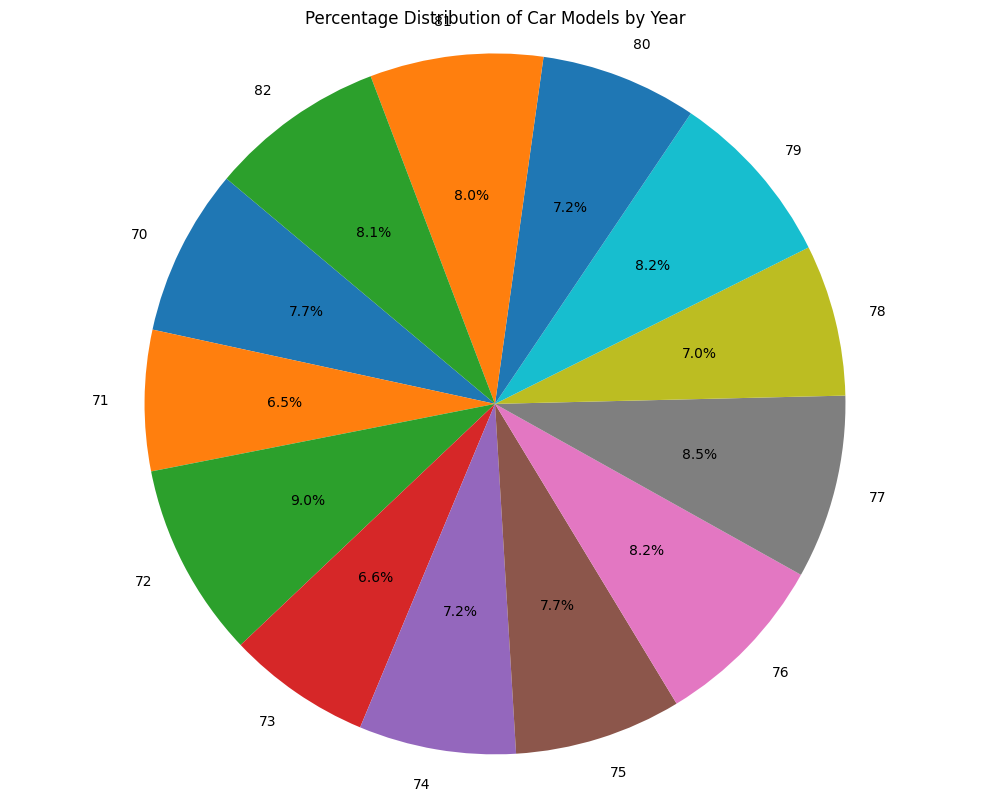

In [ ]:
# Goal: Identify the distribution of car models manufactured in each year and visualize the percentage distribution of car models by year using a pie chart.

query = """
SELECT 
    model_year,
    COUNT(DISTINCT SUBSTRING_INDEX(car_name, ' ', 1)) AS num_models,
    COUNT(DISTINCT car_name) AS total_models
FROM cars_stats
GROUP BY model_year
ORDER BY model_year
"""

model_distribution_by_year = spark.sql(query)
model_distribution_by_year.show()
model_distribution_by_year_df = model_distribution_by_year.toPandas()

model_distribution_by_year_df['percentage_distribution'] = (model_distribution_by_year_df['num_models'] / model_distribution_by_year_df['total_models']) * 100

plt.figure(figsize=(10, 8))
plt.pie(model_distribution_by_year_df['percentage_distribution'], labels=model_distribution_by_year_df['model_year'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Car Models by Year')
plt.axis('equal')  
plt.tight_layout()
plt.show()


+---------+------------------+------------------+------------------+
|     make|        avg_weight|    avg_horsepower|  avg_acceleration|
+---------+------------------+------------------+------------------+
|    buick|3553.3529411764707|136.41176470588235|14.700000000000003|
|  pontiac|         3655.3125|          136.9375|14.081249999999999|
| mercedes|            3530.0|              77.0|              20.1|
|   toyota|           2301.16|             83.44|16.099999999999998|
|     saab|           2625.25|            108.75|            15.175|
|      amc|3280.6428571428573|114.70370370370371|15.264285714285716|
|       vw|2092.6666666666665|60.833333333333336|18.816666666666666|
|  peugeot|           2972.75|              88.0|             19.55|
| chrysler|            3912.0|153.66666666666666|13.300000000000002|
| plymouth| 3218.967741935484|111.41935483870968|14.851612903225801|
|vokswagen|            1845.0|              62.0|              15.3|
|    chevy|            3717.0|142.

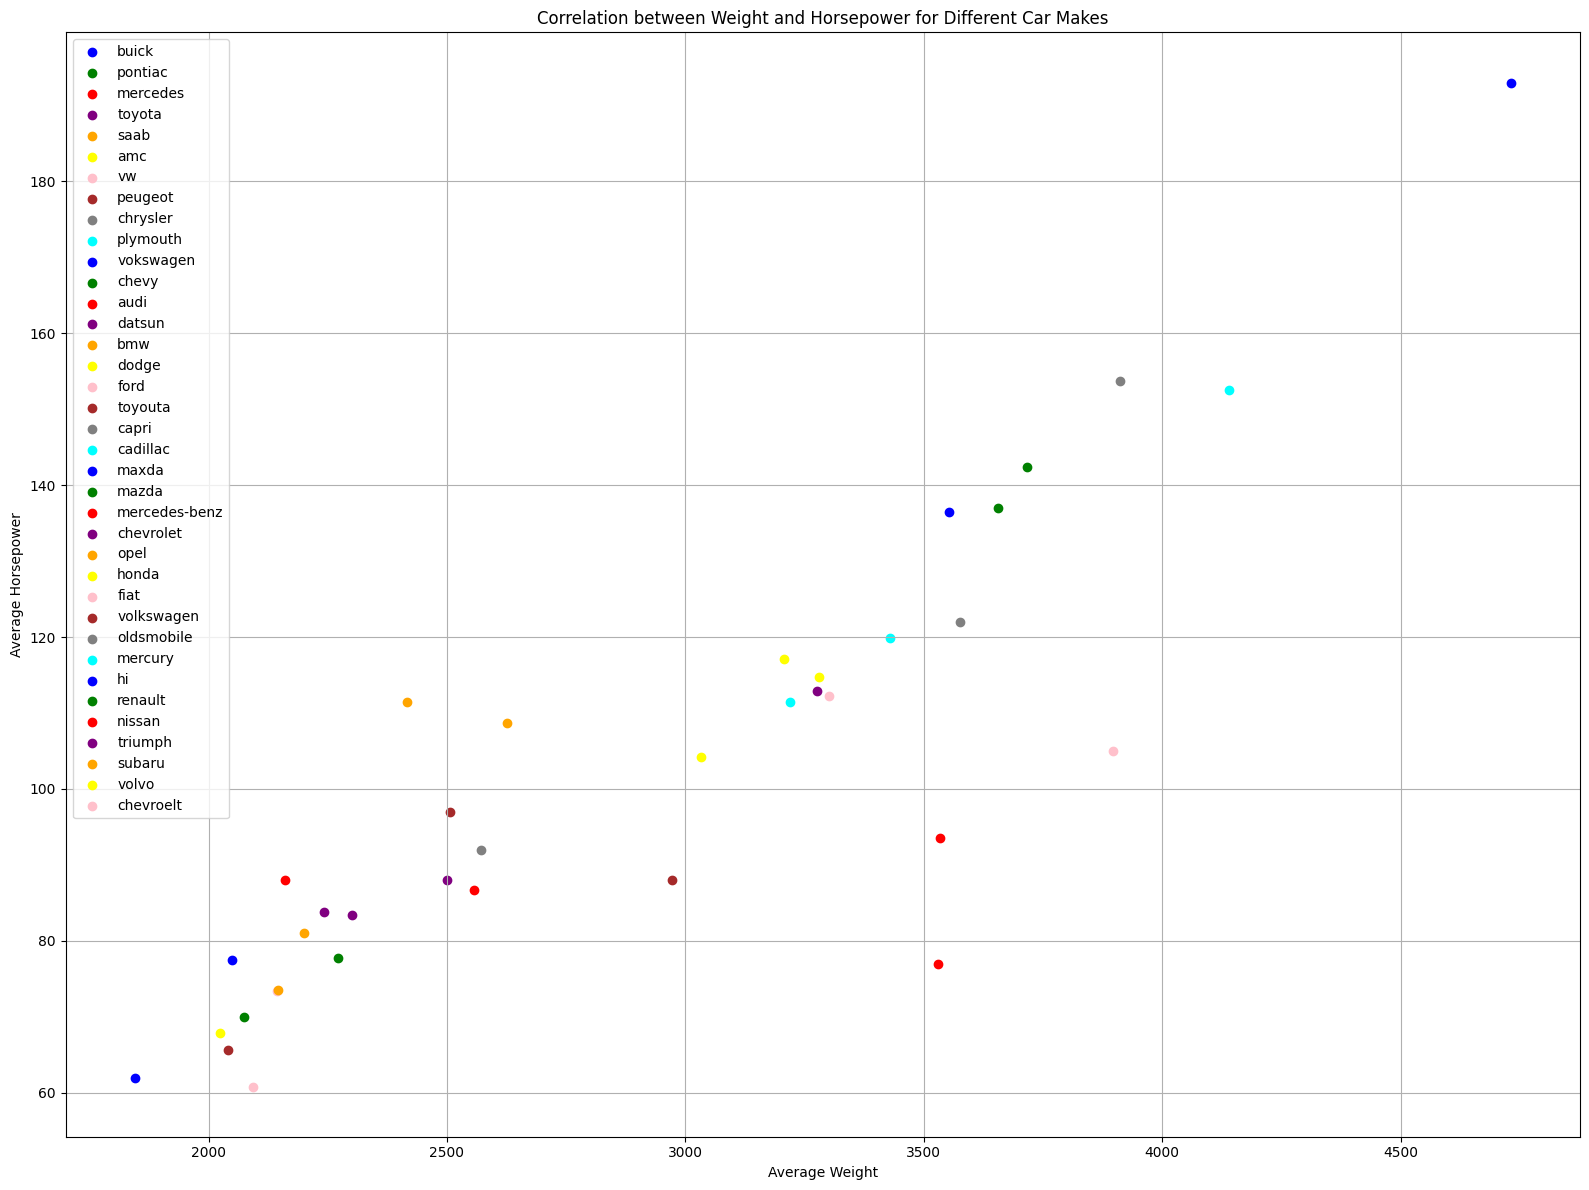

In [ ]:
#Determine the correlation between car weight, horsepower, and acceleration for cars manufactured by each make. Visualize this correlation using a scatter plot for each make.

query = """
SELECT 
    SUBSTRING_INDEX(car_name, ' ', 1) AS make,
    AVG(weight) AS avg_weight,
    AVG(horsepower) AS avg_horsepower,
    AVG(acceleration) AS avg_acceleration
FROM cars_stats
GROUP BY make
"""

make_stats = spark.sql(query)
make_stats.show()
make_stats_df = make_stats.toPandas()

plt.figure(figsize=(16, 12))
for idx, row in make_stats_df.iterrows():
    color = colors[idx % len(colors)] 
    plt.scatter(make_stats_df.loc[idx, 'avg_weight'], make_stats_df.loc[idx, 'avg_horsepower'], color=color, label=make_stats_df.loc[idx, 'make'])
plt.xlabel('Average Weight')
plt.ylabel('Average Horsepower')
plt.title('Correlation between Weight and Horsepower for Different Car Makes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



+----------+----------+------------------+------------------+------------------+------------------------------+
|      make|model_year|           avg_mpg|    avg_horsepower|  avg_acceleration|avg_horsepower_to_weight_ratio|
+----------+----------+------------------+------------------+------------------+------------------------------+
|      ford|        73|              15.2|             127.0|              15.0|           0.03406286879090226|
|      opel|        76|              25.0|              81.0|              16.9|           0.03648648648648649|
|    datsun|        74|              31.5|              64.0|              19.0|           0.03238047052871237|
|volkswagen|        74|              26.0|              67.0|              15.5|           0.03413143148242486|
| chevrolet|        78|23.233333333333334|102.66666666666667|15.966666666666667|           0.03526044647967946|
|     dodge|        80|              23.5|              97.5|             16.55|           0.03154829315

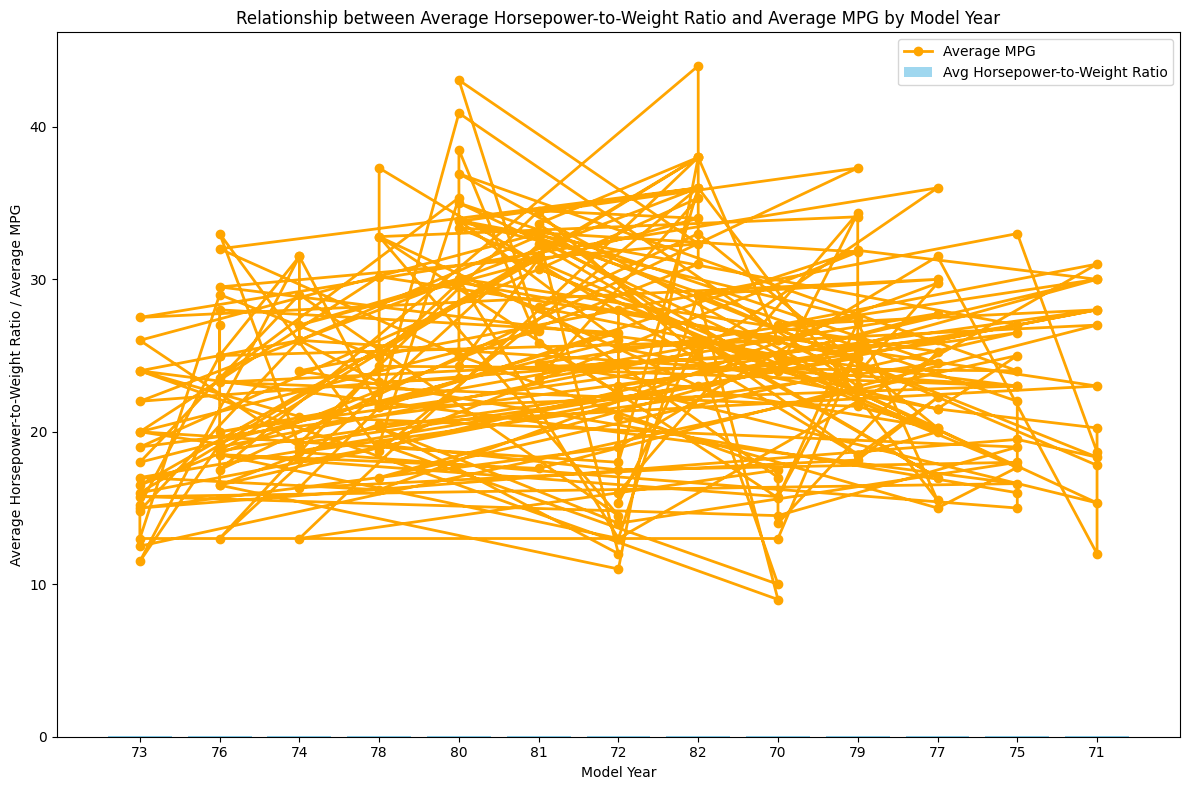

In [ ]:
#Goal: Explore the relationship between car mileage (mpg), horsepower, and acceleration for cars manufactured by each make and model year. Additionally, identify the average horsepower-to-weight ratio for cars of each make and model year. Visualize these relationships using a 3D scatter plot.
query = """
WITH avg_stats AS (
    SELECT 
        SUBSTRING_INDEX(car_name, ' ', 1) AS make,
        model_year,
        AVG(mpg) AS avg_mpg,
        AVG(horsepower) AS avg_horsepower,
        AVG(acceleration) AS avg_acceleration
    FROM cars_stats
    GROUP BY make, model_year
),
horsepower_weight_stats AS (
    SELECT 
        SUBSTRING_INDEX(car_name, ' ', 1) AS make,
        model_year,
        AVG(horsepower) / AVG(weight) AS avg_horsepower_to_weight_ratio
    FROM cars_stats
    GROUP BY make, model_year
)
SELECT 
    a.make,
    a.model_year,
    a.avg_mpg,
    a.avg_horsepower,
    a.avg_acceleration,
    h.avg_horsepower_to_weight_ratio
FROM avg_stats a
JOIN horsepower_weight_stats h
ON a.make = h.make AND a.model_year = h.model_year
"""

make_yearly_stats = spark.sql(query)
make_yearly_stats.show()
make_yearly_stats_df = make_yearly_stats.toPandas()

plt.figure(figsize=(12, 8))

plt.bar(make_yearly_stats_df['model_year'], make_yearly_stats_df['avg_horsepower_to_weight_ratio'], color='skyblue', alpha=0.8, label='Avg Horsepower-to-Weight Ratio')

plt.plot(make_yearly_stats_df['model_year'], make_yearly_stats_df['avg_mpg'], color='orange', marker='o', linestyle='-', linewidth=2, label='Average MPG')

plt.xlabel('Model Year')
plt.ylabel('Average Horsepower-to-Weight Ratio / Average MPG')
plt.title('Relationship between Average Horsepower-to-Weight Ratio and Average MPG by Model Year')
plt.legend()

plt.tight_layout()
plt.show()




+-------------+------------------+
|         make|  avg_acceleration|
+-------------+------------------+
|         ford|18.839999999999996|
|   oldsmobile|             18.54|
|           hi|              18.5|
|    chevroelt|              18.5|
|        dodge|             17.38|
|        buick|             17.18|
|      mercury|             16.96|
|mercedes-benz|              16.7|
|        volvo|              16.6|
|          amc|              16.3|
|      peugeot|              15.8|
|      pontiac|15.059999999999999|
|     cadillac|             14.75|
|    chevrolet|             14.34|
|     plymouth|14.080000000000002|
|       toyota|13.866666666666667|
|        chevy|              13.5|
|       datsun|13.233333333333334|
|     chrysler|13.059999999999999|
+-------------+------------------+



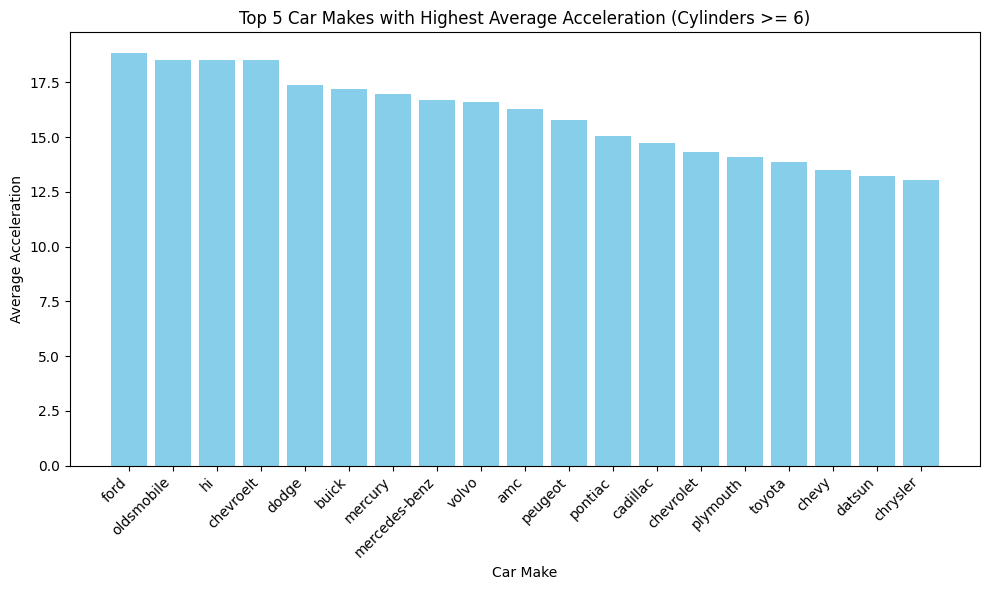

In [ ]:
# Query to identify top 5 car makes with highest average acceleration, considering models with at least 6 cylinders
query = """
WITH filtered_cars AS (
    SELECT 
        SUBSTRING_INDEX(car_name, ' ', 1) AS make,
        acceleration,
        ROW_NUMBER() OVER(PARTITION BY SUBSTRING_INDEX(car_name, ' ', 1) ORDER BY acceleration DESC) AS rank
    FROM cars_stats
    WHERE cylinders >= 6
)
SELECT 
    make,
    AVG(acceleration) AS avg_acceleration
FROM filtered_cars
WHERE rank <= 5
GROUP BY make
ORDER BY avg_acceleration DESC
"""

top_acceleration_makes = spark.sql(query)
top_acceleration_makes.show()
top_acceleration_makes_df = top_acceleration_makes.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_acceleration_makes_df['make'], top_acceleration_makes_df['avg_acceleration'], color='skyblue')
plt.xlabel('Car Make')
plt.ylabel('Average Acceleration')
plt.title('Top 5 Car Makes with Highest Average Acceleration (Cylinders >= 6)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


